In [2]:
import json
import pandas as pd
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import display, SVG
from ergochemics.mapping import operator_map_reaction
from ergochemics.standardize import standardize_rxn
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import polars as pl


In [6]:
pure_bkms = pd.read_csv("data/raw/pathway/Reactions_BKMS.csv", sep='\t')
pure_bkms.head()

/tmp/ipykernel_140219/473144253.py:1: DtypeWarning: Columns (5,7,9,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pure_bkms = pd.read_csv("data/raw/pathway/Reactions_BKMS.csv", sep='\t')


,ID,EC_Number,Recommended_Name,Reaction,Reaction_ID_BRENDA,Reaction_ID_KEGG,Reaction_ID_MetaCyc,Reaction_ID_SABIO_RK,BRENDA_Pathway_Name,KEGG_Pathway_ID,KEGG_Pathway_Name,MetaCyc_Pathway_ID,MetaCyc_Pathway_Name,Stoichiometry_Check,Missing_Substrate,Missing_Product,Commentary_KEGG,Commentary_MetaCyc,Remark
0,1,5.3.3.3,vinylacetyl-CoA DELTA-isomerase,vinylacetyl-CoA = (E)-but-2-enoyl-CoA,BR1,R03031,VINYLACETYL-COA-DELTA-ISOMERASE-RXN,NaN,NaN,rn00650,Butanoate metabolism,NaN,NaN,NaN,NaN,NaN,NaN,NaN,natural substrates
1,2,6.3.2.1,pantoate-beta-alanine ligase (AMP-forming),ATP + (R)-pantoate + beta-alanine = AMP + diph...,BR101,R02473,PANTOATE-BETA-ALANINE-LIG-RXN,2406,pantothenate biosynthesis,rn00410; rn00770; rn01110,beta-Alanine metabolism; Pantothenate and CoA ...,PANTO-PWY,phosphopantothenate biosynthesis I,NaN,NaN,NaN,NaN,NaN,natural substrates
2,3,6.3.2.10,UDP-N-acetylmuramoyl-tripeptide-D-alanyl-D-ala...,ATP + UDP-N-acetylmuramoyl-L-alanyl-gamma-D-gl...,BR102,R04573,6.3.2.10-RXN,4244,peptidoglycan biosynthesis,rn00550,Peptidoglycan biosynthesis,PWY-6386,UDP-N-acetylmuramoyl-pentapeptide biosynthesis...,NaN,NaN,NaN,NaN,NaN,natural substrates
3,4,6.3.2.4,D-Alanine-D-alanine ligase,ATP + UDP-N-acetylmuramoyl-L-alanyl-gamma-D-gl...,BR102,R04573,6.3.2.10-RXN,4244,peptidoglycan biosynthesis,rn00550,Peptidoglycan biosynthesis,PWY-6386,UDP-N-acetylmuramoyl-pentapeptide biosynthesis...,NaN,NaN,NaN,NaN,NaN,natural substrates
4,5,6.3.2.11,carnosine synthase,ATP + L-histidine + beta-alanine = ADP + phosp...,BR103,R01164,CARNOSINE-SYNTHASE-RXN,NaN,NaN,rn00340; rn00410,Histidine metabolism; beta-Alanine metabolism,PWY66-420,carnosine biosynthesis,NaN,NaN,NaN,NaN,NaN,natural substrates


In [2]:
def rm_stereo(smarts: str) -> str:
    return smarts.replace('/', '').replace("\\", '').replace('@', '')

In [ ]:
with open('data/raw/pathway/rules/bkms-reactions.json') as f:
    bkms = json.load(f)

In [3]:
with open("/home/stef/enz_rxn_data/artifacts/rules/bkms-and-reaxys-tempaltes.json", 'r') as f:
    crules = json.load(f)

In [4]:
len(crules), type(crules)

(171707, list)

In [5]:
rule_sets = set()
for r in crules:
    rule_sets.add(r['template_set'])

In [6]:
rule_sets

{'bkms', 'reaxys'}

In [7]:
biorules = [r for r in crules if r['template_set'] == 'bkms']
print(len(biorules))

7984


In [ ]:
n_w_stereo = sum(1 for r in biorules if '/' in r['reaction_smarts'] or '\\' in r['reaction_smarts'] or '@' in r['reaction_smarts'])
n_w_stereo

4586

In [63]:
biorules_w_stereo = [r for r in biorules if '/' in r['reaction_smarts'] or '\\' in r['reaction_smarts'] or '@' in r['reaction_smarts']]

In [73]:
def map_rev_map(rxn: str, rule: str) -> str:
    res = operator_map_reaction(rxn, rule)

    if res.did_map:
        return res
    else:
        rxn = '>>'.join(reversed(rxn.split('>>')))
        res = operator_map_reaction(rxn, rule)

    return res

ds = 100
for r in biorules_w_stereo[::ds]:
    ref_rxns = r['references']
    rxn = bkms[ref_rxns[0]]['smiles']
    rule = r['reaction_smarts']
    rule_no_stereo = rm_stereo(rule)
    rxn_no_stereo = standardize_rxn(rxn, remove_stereo=True, do_neutralize=False, do_find_parent=False)

    try:
        res = map_rev_map(rxn, rule)
        res_no_stereo = map_rev_map(rxn_no_stereo, rule_no_stereo)
        print(f"Mapped with stereo: {res.did_map} without stereo: {res_no_stereo.did_map}")
    except Exception as e:
        continue


Mapped with stereo: True without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: True without stereo: True
Mapped with stereo: True without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: True without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: True without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: False without stereo: True
Mapped with stereo: True without stereo: True
Mapped with stereo: False without stereo: False
Mapped with stereo: True without stereo: True
Mapped with stereo: False without stereo: False
Mapped with stereo: True without stereo: True
Mapped with stereo: True without stereo: True
Mapped with stereo: False without stereo: False
Mapped with stereo:

In [30]:
for rule in biorules:
    rule['reaction_smarts'] = rm_stereo(rule['reaction_smarts'])

In [34]:
for rule in biorules:
    assert '/' not in rule['reaction_smarts'], f"Found '/' in rule index {i}"
    assert '\\' not in rule['reaction_smarts'], f"Found '\\' in rule index {i}"
    assert '@' not in rule['reaction_smarts'], f"Found '@' in rule index {i}"


In [37]:
df = pd.DataFrame(
    data=[
        (i, r['reaction_smarts'], r['_id'])
        for i, r in enumerate(biorules)
    ],
    columns=['id', 'smarts', 'levin_id']
)

df.head()

,id,smarts,levin_id
0,0,[CH3;D1;+0:1][CH;D2;+0:2]=[CH;D2;+0:3][C:4]=[O...,0f94deda94405d6784354f53c192a2b5
1,1,[C:4]-[NH;D2;+0:5]-[C;H0;D3;+0:1](-[C:2])=[O;D...,e90495e032398914a2bc30231f78c717
2,2,[#7:4]-[C:5](=[O;D1;H0:6])-[C:7]-[NH;D2;+0:8]-...,0b3c7f7b62406a64fc3ed6b82f0b53b6
3,3,[C:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[NH;D2;+0:4...,593282ac9cb5e1ec3fd083ff8b6bcb5e
4,4,[O;D1;H0:1]=[C:2]1-[#8:3]-[C:4]-[C;H0;D3;+0:5]...,4f5920ee796e6e28d607b8c9224f9b3d


In [ ]:
# df.to_csv('/home/stef/enz_rxn_data/artifacts/rules/levin_no_stereo_rules.csv', index=False)

In [41]:
levin_mapped = pl.read_parquet(
    "data/processed/pathway/mapped_known_reactions_x_levin_no_stereo_rules.parquet"
)
levin_mapped.head()

rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id
str,str,str,str,str,i64
"""01aa17877dfc9b22150dd5960fca9c…","""O=C(COP(=O)(O)O)C(O)CO>>O=C(CO…","""[O:7]=[C:5]([CH2:6][O:8][P:9](…","""[#8:1]-[C:2]-[CH;D3;+0:3](-[OH…","""11,10,8,9,1,2,0>>0,1,2,3,4,5,6""",2718
"""0259bb0b198cb1987384c64f55fece…","""CC(C)=CCCC(C)C1CCC2C3=C(CCC21C…","""[CH3:27][C:26]([CH3:28])=[CH:2…","""[C:1]-[CH;D3;+0:2](-[C;H3;D1;+…","""22,24,25,26,27,18,13,12>>12,13…",1248
"""02ae61600fca82d7d0e1012b9d4764…","""NC(CC(=O)O)CC(=O)O>>NC(CCC(=O)…","""[NH2:1][CH:3]([CH2:4][C:5](=[O…","""[NH2;D1;+0:1]-[CH;D3;+0:3](-[C…","""0,1,2,3,4,5,6,7,8,9>>0,1,2,3,4…",4230
"""02c74548800591dcb3692026fa9760…","""CC(C)=CCCC(C)=CC=CC(C)=CC=CC(C…","""[CH3:39][C:38]([CH3:40])=[CH:3…","""[C:1][C:2]=[C:3][CH;D3;+0:4]1-…","""27,29,30,31,32,33,34,35,36,37,…",1000
"""03264e61dd85089b054beed9445cc5…","""CSCC(O)C(O)C(=O)COP(=O)(O)O>>C…","""[CH3:15][S:14][CH2:13][CH:4]([…","""[#8:1]-[CH2;D2;+0:2]-[C;H0;D3;…","""10,9,7,8,5,3,4>>3,4,5,6,11,12,…",131


In [43]:
std_bkms = pl.read_parquet(
    "data/processed/pathway/std_bkms.parquet"
)
print(std_bkms.shape)
std_bkms.head()

(13872, 6)


id,smarts,ec,name_rxn,name,levin_id
str,str,str,str,str,i32
"""cc988ce67663775627d1c9d5ec7e8e…","""CC(C)(COP(=O)(O)OP(=O)(O)OCC1O…","""1.14.13""","""p-Coumaroyl-CoA <=> Caffeoyl-C…",null,5604
"""0d492bf475678b0d80d93387251338…","""O=S(=O)(O)c1ccc2c(O)c(O)ccc2c1…","""1.14.99""","""1,6-Naphthalenedisulfonic acid…",null,11004
"""2c34c9526b2dddde44ea91bef71480…","""CC(CCC(=O)O)C1CCC2C3C(=O)CC4CC…","""1.1.1.393""","""3,7,12-trioxo-5beta-cholan-24-…","""3beta-hydroxycholanate 3-dehyd…",3822
"""98fccb652ef90ad902e7d4d8af705a…","""Oc1ccc2ccc3ccc(O)c4ccc1c2c34>>…","""SPONTANEOUS""","""1-Hydroxypyrene-7,8-oxide <=> …",null,11988
"""4ca6375bdb9a1525731c39b7e2bb0b…","""NC(=O)c1ccc[n+](C2OC(COP(=O)(O…","""3.6.1.18""","""NAD+ + H2O = AMP + NMN""","""FAD diphosphatase""",1162


In [44]:
rhea = pl.read_parquet(
    "data/processed/pathway/known_reactions.parquet"
)
rhea.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P30109"", ""P57108"", … ""P46436""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""Q0UK48"", ""A0A0C6E0I7"", … ""A0A0C6DWS6""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""P0DO30"", ""A0A482N9V7""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [45]:
bkms_rhea_intersect = std_bkms.filter(
    pl.col("id").is_in(rhea['id'].to_list())
)
print(bkms_rhea_intersect.shape)

(895, 6)


In [56]:
bkms_not_in_rhea = std_bkms.filter(
    ~pl.col("id").is_in(rhea["id"].to_list())
)
bkms_not_in_rhea.shape, bkms_not_in_rhea['levin_id'].to_list()

((12977, 6),
 [5604,
  11004,
  3822,
  11988,
  1162,
  15248,
  10698,
  5654,
  14122,
  1980,
  9940,
  13809,
  1872,
  2138,
  3936,
  6241,
  8559,
  4244,
  12019,
  14191,
  5780,
  6543,
  10624,
  11344,
  8843,
  1068,
  13933,
  3402,
  12831,
  8267,
  539,
  5113,
  11464,
  8137,
  7061,
  8780,
  8652,
  11474,
  11813,
  14295,
  11171,
  4521,
  2679,
  12094,
  2287,
  2006,
  3611,
  12046,
  4446,
  11861,
  11448,
  14829,
  5748,
  9999,
  6240,
  8825,
  5470,
  9734,
  701,
  363,
  3983,
  1752,
  4208,
  4965,
  7924,
  9583,
  11139,
  11461,
  6632,
  10917,
  11467,
  11974,
  14300,
  6831,
  13789,
  2329,
  10219,
  15060,
  667,
  362,
  9726,
  14260,
  8805,
  15227,
  2420,
  13892,
  7696,
  13030,
  267,
  6175,
  10595,
  10446,
  13770,
  3926,
  4162,
  15046,
  6473,
  8926,
  14503,
  14216,
  15088,
  3080,
  4079,
  11360,
  2019,
  136,
  13696,
  13018,
  15023,
  2686,
  12866,
  11837,
  10932,
  7334,
  9740,
  1695,
  12693,
  2412,


In [60]:
entry = bkms[10698]
entry

{'ID': 10698,
 'EC_Number': '3.2.1',
 'Recommended_Name': None,
 'Reaction': 'maltotriose + H2O = maltose + D-glucose',
 'Reaction_ID_BRENDA': 'BS259694,BS361255,BS361273,BS372381,BS374650,BS380766,BS382260',
 'Reaction_ID_KEGG': None,
 'Reaction_ID_MetaCyc': 'RXN-12188,RXN0-5183',
 'Reaction_ID_SABIO_RK': '102046585',
 'BRENDA_Pathway_Name': 'starch degradation',
 'KEGG_Pathway_ID': None,
 'KEGG_Pathway_Name': None,
 'MetaCyc_Pathway_ID': 'PWY-6735; GLYCOCAT-PWY',
 'MetaCyc_Pathway_Name': 'starch degradation IV; glycogen degradation I',
 'Stoichiometry_Check': None,
 'Missing_Substrate': None,
 'Missing_Product': None,
 'Commentary_KEGG': None,
 'Commentary_MetaCyc': 'In this reaction |FRAME: Maltodextrins| is hydrolyzed to a mixture of |FRAME: MALTOSE| and |FRAME: ALPHA-GLUCOSE|.  Stoichiometric coefficients are undetermined.',
 'Remark': 'natural substrates',
 'smiles': 'OC[C@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@H](O[C@@H]3[C@@H](CO)OC(O)[C@H](O)[C@H]3O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[

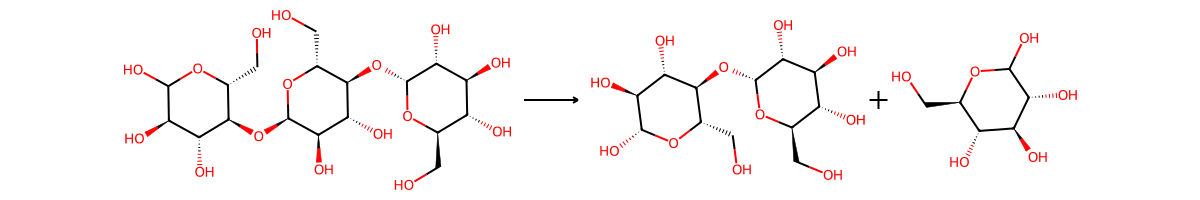

In [61]:
SVG(draw_reaction(entry['smiles']))